In [66]:
import copy, os, sys, time
from datetime import timedelta
import imageio
import numpy as np
import matplotlib as mpl
import matplotlib.cbook
import matplotlib.pyplot as plt 
from pathlib import Path
import warnings

from bmi_topography import Topography
from IPython.display import clear_output
from landlab.io.netcdf import write_netcdf, read_netcdf
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid
from landlab.plot import graph
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler,
                                PriorityFloodFlowRouter,
                                BedrockLandslider,
                                FireGenerator,
                                ChannelProfiler, 
                                SpaceLargeScaleEroder)
from landlab.components.landslides import LandslideProbability
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.utils import get_watershed_mask

# Modules are autoreloaded for easy modification
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Larger matplotlib figures 
plt.rcParams['figure.figsize'] = [10, 10] 
# matplotlib warnings are suppressed for presentation purposes
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  - (space.K_sed - self.K_sed0) * dt / self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire_mean=1, K_sed_boost=1, dt=1, dx=1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire_mean = R_fire_mean # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        self.fireTimes = [] # empty list to be filled with the times when fires happened
        self.fireSizes = [] # empty list to be filled with the sizes of fires that happened
        self.dx = dx # size of the grid used by space
        
    @property
    def R_fire(self):
        """
        choose a random fire size from an exponential distribution
        having mean size R_fire_mean
        """
        return np.random.exponential(self.R_fire_mean) / 1000 # exponential random var
        
        
    def fire(self, space, grid, t):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if..
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(- self.dt * self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs: # if fire does not occur...
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            # changed_nodes = self._within(center, space , grid) # based on Laurent's code.
            changed_nodes = self._within(center, self.R_fire, grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes] += self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center

            s1 = grid.x_of_node[center]
            s2 = grid.y_of_node[center]
            A = len(changed_nodes) * self.dx ** 2 / 1e6 # area of the fire if it occcurred in km^2
            print(r'fire at ({},{}) of area {} square km.'.format(s1, s2, round(A, 3)))
            
            # save the time and magnitude of the fire
            self.fireTimes.append(t) # time at which the fire happened
            self.fireSizes.append(A) # area of the fire which happened.
                        
        
    def _within(self, center, space, grid):
        """
        Return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < self.R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire


In [74]:
# Show Landslide erosion and deposition draped over the shaded topographic relief
def landslide_plot(grid):
    cmap1 = copy.copy(mpl.cm.get_cmap("Blues"))
    thres_drape1 = 0.01
    thres_drape2 = 0.01
    alpha  = .8
    alpha2 = .8
    drape1 = np.sqrt(grid.at_node["landslide__erosion"])
    drape2 = np.sqrt(grid.at_node["landslide__deposition"])
    cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
    cmap2 = copy.copy(mpl.cm.get_cmap("winter_r"))
    plt.figure(figsize=(10,10))
    imshowhs_grid(grid, "topographic__elevation",
                  plot_type='Drape2',         
                  drape1 = drape1,
                  cmap=cmap1,
                  thres_drape1=thres_drape1,
                  alpha=alpha,
                  drape2 = drape2,
                  cmap2=cmap2,
                  thres_drape2=thres_drape2,
                  alpha2=alpha2,
                  add_double_colorbar=True, 
                  cbar_tick_size =8,
                  cbar_label_color='red',
                  cbar_label_fontweight = 'normal',
                  add_label_bbox = True, )
    plt.show()

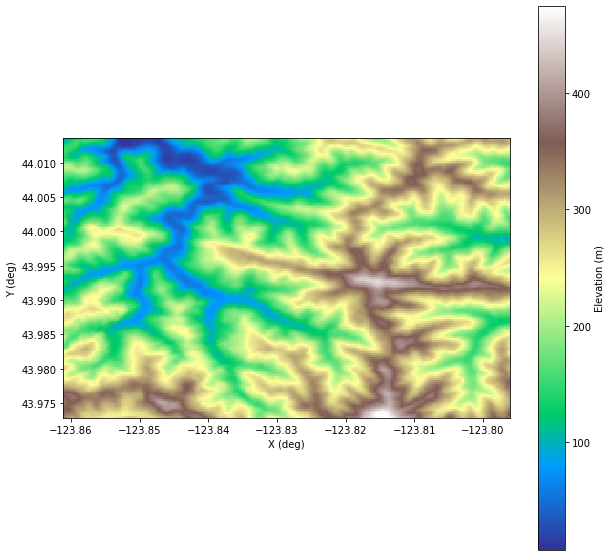

In [68]:
topo = Topography(
    dem_type="SRTMGL1",
    api_key='1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 
            'topographic__elevation',
            cmap=cmap,
            grid_units=("deg", "deg"),
            colorbar_label="Elevation (m)"
           )
plt.show()

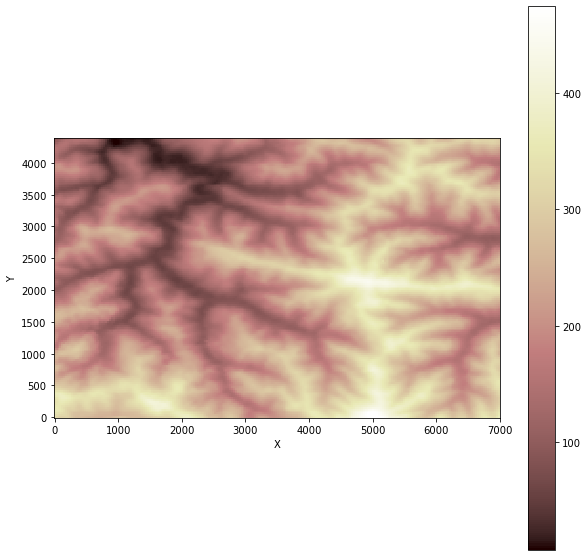

In [69]:
grid = RasterModelGrid((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30)
grid.add_field('topographic__elevation', elev, at = 'node')
imshow_grid(grid,'topographic__elevation')
dx = np.diff(grid.x_of_node)[0]

In [70]:
printit = True        # be verbose with printing output or not?

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
timestep = 1                   # timestep in years
runtime_sp = 10             # length of the simulation in years
num_timestep = runtime_sp//timestep  # number of timesteps
uplift = 0.002                # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp = 0.00001            # erodibility coefficient
m_sp = 0.5                # Drainage area exponent
n_sp = 1                  # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = timestep * 15    # time it takes the erodibility perturbutions to decay

# Burner
# R_fire_mean = len(grid.x_of_node)*dx/500    # Mean fire radius in m. 1/20 the size of the grid.
R_fire_mean = len(grid.x_of_node) * dx / 10    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1 / (2 * timestep)          # Fire frequency in #/yr. This is one every 10
# fire_freq = 1/(30*timestep)          # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5 * K_sed0           # The increase in sediment erodibility due to fire
K_sp = 0.00001          # erodibility coefficient
m_sp = 0.5              # Drainage area exponent
n_sp = 1                # Slope exponent

fr = FlowAccumulator(grid, flow_director=flow_metric)
df = DepressionFinderAndRouter(grid)

In [71]:
#Add soil to the drainage network (for SPACE)
_ = grid.add_zeros('soil__depth', at='node', dtype=float) 
grid.at_node['soil__depth'] += 0.5
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

In [72]:
K_sed = np.ones(grid.shape) * K_sed0 # the initial soil erodibility per node
ha = Space(
    grid,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp = n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br
)

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=timestep
               )

In [73]:
flow_metric = "D8"
num_rows, num_columns = grid.shape 

landslide_flow_router = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

ls = BedrockLandslider(
    grid, 
    angle_int_frict=84, #have 40 degrees changed to %
    landslides_return_time=1e2, #changed from default of 1e3
    cohesion_eff=1e3,) #reduced from 1e3 - just taking a guess

#bedrock landslider
node_next_to_outlet = num_columns + 1
np.random.seed(seed=5000)

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)

grid.set_watershed_boundary_condition_outlet_id(
    0, grid.at_node['topographic__elevation'], -9999.0
)

space_flood_router = PriorityFloodFlowRouter(grid, flow_metric=flow_metric, suppress_out=True)
space = SpaceLargeScaleEroder(
    grid,
    K_sed=0.01, # erodibility for sediment
    K_br=0.01, # erodibility for bedrock
)

sed_flux = np.zeros(int(runtime_sp // timestep))

-- 0 years simulated -- 8.7 seconds runtime --


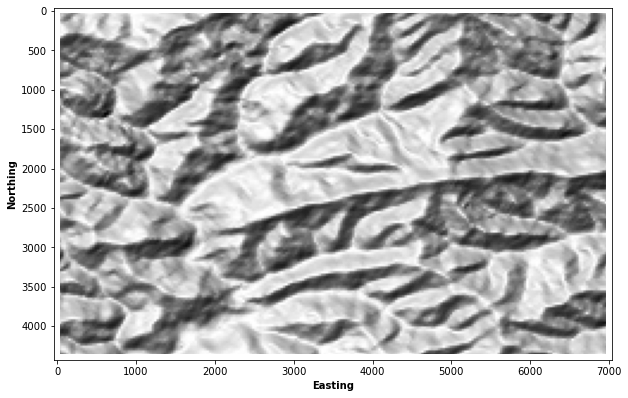

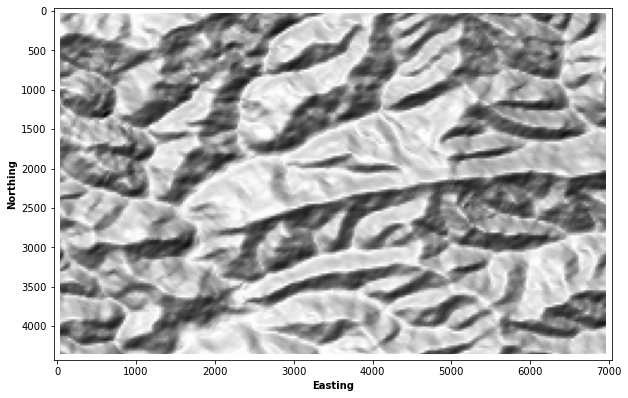

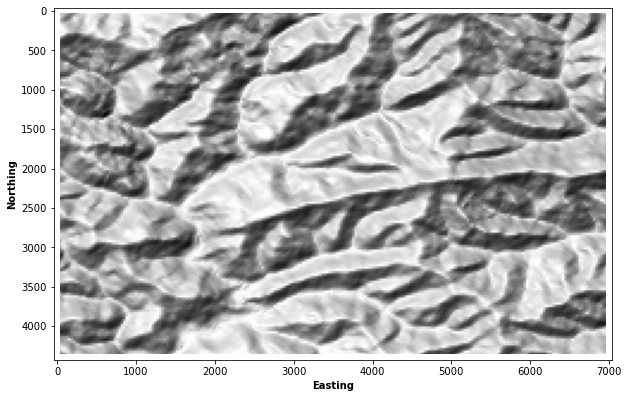

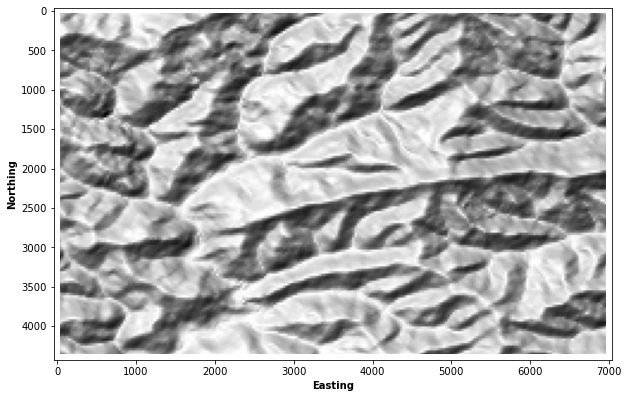

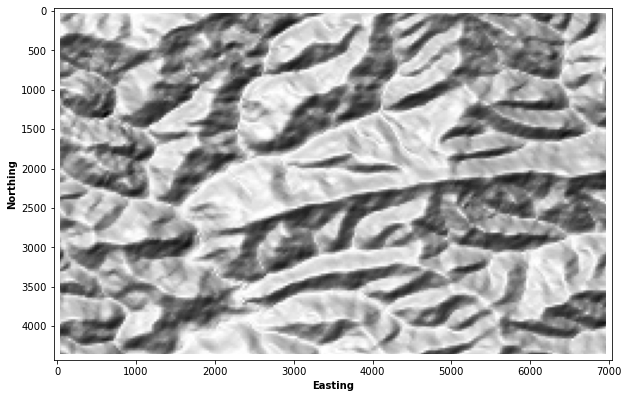

-- 5 years simulated -- 65.2 seconds runtime --


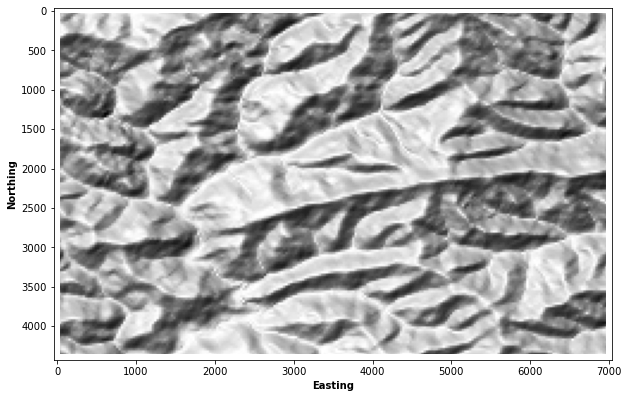

fire at (3660.0,1860.0) of area 0.0 square km.


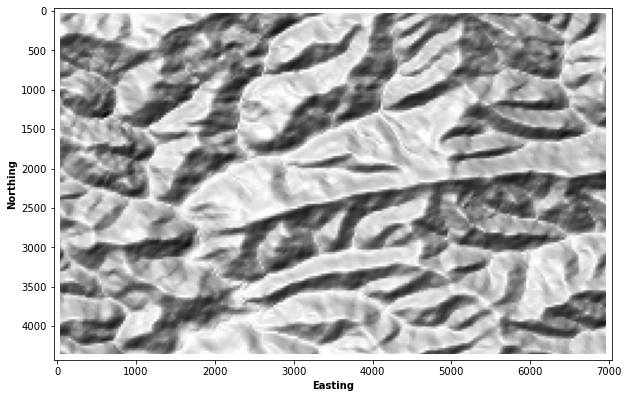

fire at (5820.0,630.0) of area 0.001 square km.


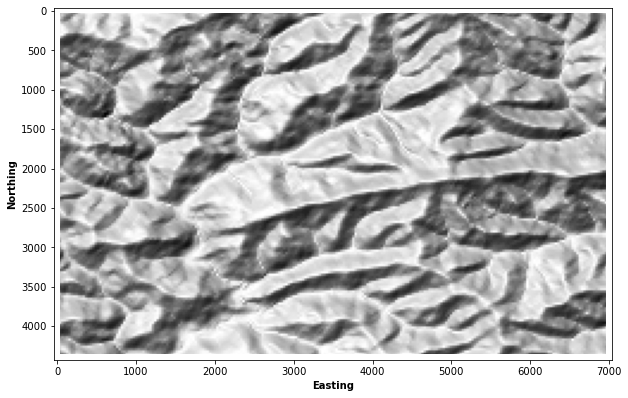

fire at (6990.0,4320.0) of area 0.0 square km.


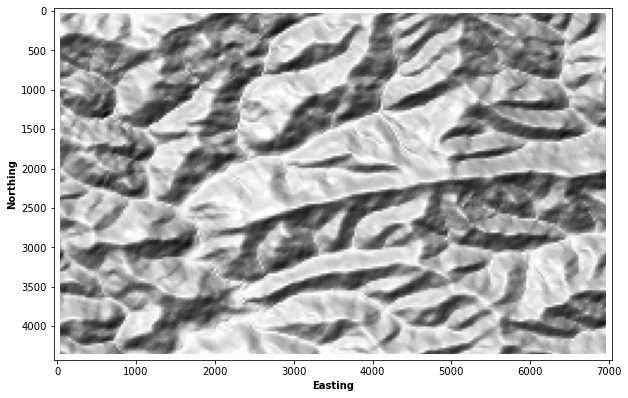

fire at (1020.0,3060.0) of area 0.0 square km.


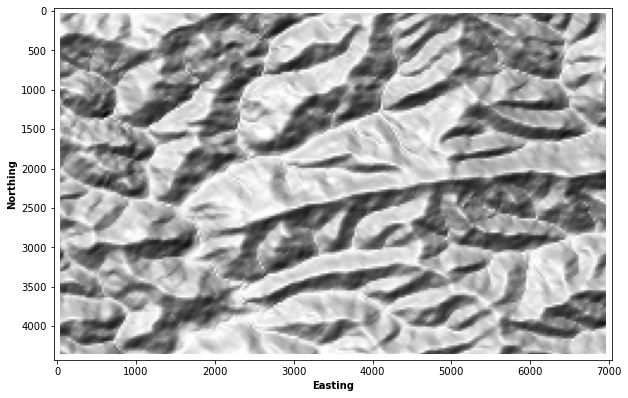

runtime: 0:01:52.841810


In [75]:
start_time = time.time() # for the purposes of tracking the runtime of the simulation loop

sedflux = np.empty(shape=num_timestep)
t_sedflux = np.empty(shape=num_timestep)

for i in range(num_timestep): # iterate through timesteps
    fr.run_one_step()           # accumulate the flow
    # df.map_depressions()        # find landscape depressions (which do not erode)
    ha.run_one_step(dt=timestep)   # step the transport model
    es.stepper(ha, dt=timestep)     # decay the erodibility back toward baseline from the former timestep
    # burner.fire(ha, grid, it*timestep)          # light any fires (increase erodibility)
    burner.fire(ha, grid, 1)          # light any fires (increase erodibility)
    grid.at_node['bedrock__elevation'][grid.core_nodes] += uplift * timestep # incorporate uplift
    sedflux[i] = grid.at_node['sediment__flux'][len(grid.x_of_node)-2+1]
    t_sedflux[i] = i * timestep
    if (i*timestep % 5 == 0) and printit: # if a decade has gone by, then print
        # clear_output(wait=True) # jupyter functionality to print over previous output
        # let us know how long it has been running
        print("--", i*timestep, "years simulated -- %s seconds runtime --" % round((time.time() - start_time), 1))

    grid.at_node['k_sed'] = K_sed
    
    # run the bedrock landslide
    landslide_flow_router.run_one_step()
    ls.run_one_step(dt=timestep)
    
    # run space
    space_flood_router.run_one_step()
    _ = space.run_one_step(dt=timestep)
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]
    
    landslide_plot(grid)
    
print(f"runtime: {str(timedelta(seconds=(time.time() - start_time)))}")

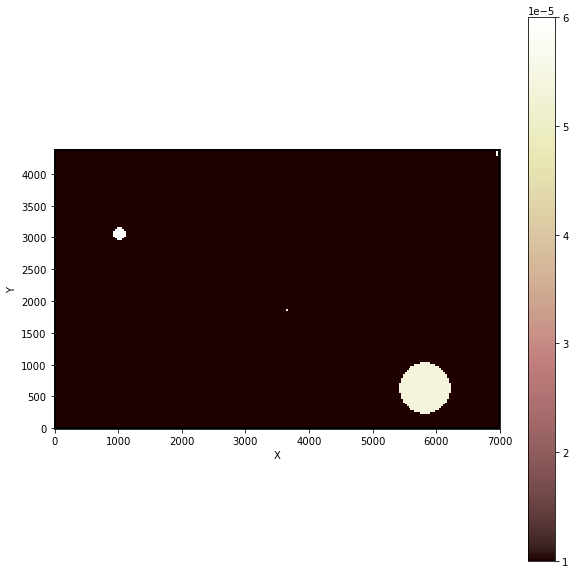

In [77]:
imshow_grid(grid,'k_sed')

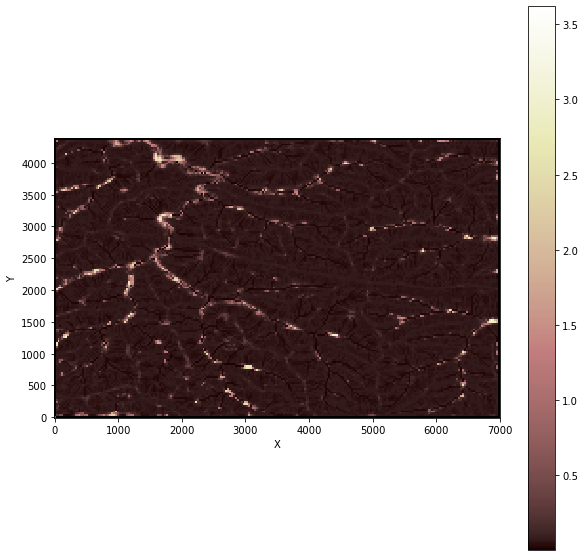

In [78]:
imshow_grid(grid,'soil__depth')

Text(0.5, 1.0, 'Fire magnitudes through time')

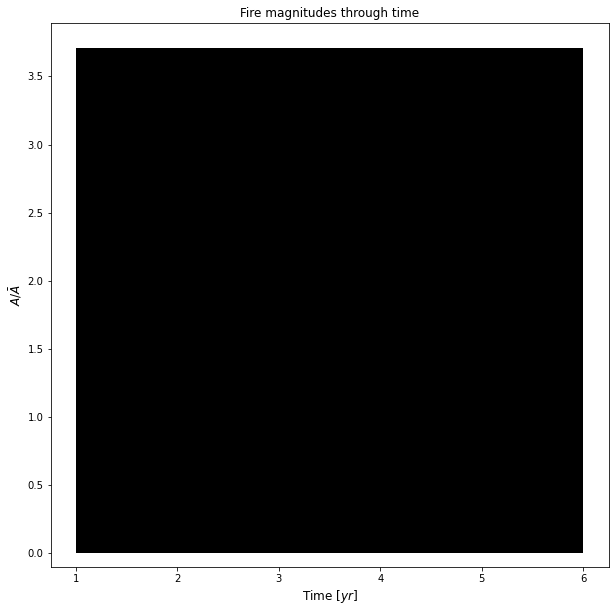

In [79]:
plt.bar(burner.fireTimes, burner.fireSizes/np.mean(burner.fireSizes), width=5, align='edge', lw=2, color='black')
plt.xlabel("Time [$yr$]", fontsize=12)
plt.ylabel(r"$A/\bar{A}$", fontsize=12)
plt.ylim(-0.1)
plt.title('Fire magnitudes through time', fontsize=12)

In [80]:
def list_keys(grid):
    for group in grid.groups:
        for field in grid.keys(group):
            print(field)
list_keys(grid)

topographic__elevation
water__unit_flux_in
drainage_area
flow__data_structure_delta
flow__upstream_node_order
surface_water__discharge
flow__sink_flag
flow__link_to_receiver_node
flow__receiver_node
topographic__steepest_slope
depression__depth
depression__outlet_node
is_pit
flood_status_code
soil__depth
sediment__influx
sediment__outflux
sediment__flux
bedrock__elevation
flow__receiver_proportions
hill_drainage_area
hill_surface_water__discharge
hill_flow__upstream_node_order
hill_topographic__steepest_slope
hill_flow__receiver_node
hill_flow__receiver_proportions
LS_sediment__flux
landslide__erosion
landslide__deposition
landslide_sediment_point_source
squared_length_adjacent
k_sed
depression_free_elevation
